# Práctica 5 - Filtrado de Spam usando Bayes Ingenuo

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe de la práctica. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para la P5 con el nombre NIP_P5.ipynb

Imports necesarios para ejecutar la práctica

In [1]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

Carga del fichero ZIP con todos los correos

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8" -O "enron.zip" && rm -rf /tmp/cookies.txt
!unzip "enron.zip"

Lectura de los emails y carga en las estructuras de datos

In [ ]:
def read_folder(folder):
    mails = []
    file_list = glob.glob(folder)  # List mails in folder
    num_files = len(file_list)
    for i in range(0, num_files):
        i_path = file_list[i]
        i_file = open(i_path, 'rb')
        i_str = i_file.read()
        i_text = i_str.decode('utf-8', errors='ignore')  # Convert to Unicode
        mails.append(i_text)  # Append to the mail structure
        i_file.close()
    return mails

def load_enron_folders(datasets):
    path = './'
    ham = []
    spam = []
    for j in datasets:
        ham  = ham  + read_folder(path + '/enron' + str(j) + '/ham/*.txt')
        spam = spam + read_folder(path + '/enron' + str(j) + '/spam/*.txt')
    num_ham  = len(ham)
    num_spam = len(spam)
    print("mails:", num_ham+num_spam)
    print("ham  :", num_ham)
    print("spam :", num_spam)

    mails = ham + spam
    labels = [0]*num_ham + [1]*num_spam
    mails, labels = shuffle(mails, labels, random_state=0)
    return mails, labels

print("Loading files...")

print("------Loading train and validation data--------")
mails, y = load_enron_folders([1,2,3,4,5])

print("--------------Loading Test data----------------")
mails_test, y_test = load_enron_folders([6])

Código para generar una bolsa de palabras que cuenta el número de apariciones de cada palabra en la lista de correos

Crea una matriz X con tantas filas como correos (27716) y tantas columnas como palabras de la BD. El elemento (i,j) de la matriz contiene el número de ocurrencias de la palabra j en el correo i

In [4]:
vectorizer  = CountVectorizer(ngram_range=(2, 2))  # Instancia de bolsa de palabras con palabras individuales como características
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test

Aprendizaje de las probabilidades utilizando un modelo de distribución Bernoulli.

Consulta la documentación de sklearn para entender los parámetros.

In [5]:
classifier = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

BernoulliNB()

Cálculo de métricas del clasificador utilizando los datos de test

F1-score of the test:  97.23%
Confusion Matrix:
[[1265  235]
 [  20 4480]]


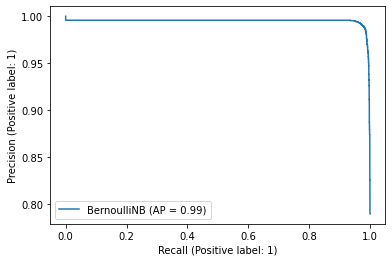

In [6]:
y_pred = classifier.predict(X_test)
f1_score=metrics.f1_score(y_test, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)
# metrics.plot_precision_recall_curve(classifier,X_test,y_test) # deprecated
metrics.PrecisionRecallDisplay.from_estimator(classifier,X_test,y_test)

EJERCICIOS

In [7]:
def tryBest(p: float, method: str) -> None:
  DATA_SCORE = [0,0,0,0] # score, alpha, y_test, y_pred
  alphas = [i/100 for i in range(1, 201) if i % 5 == 0]
  # cabecera
  print(f"{(1-p)*100}% - test\n{p*100}% - validation")

  for alpha in alphas:
    # prepara los datos de entrenamiento y validación
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, y, test_size=p)
    
    # prepara el método
    if method == "BernoulliNB":
      classifier = BernoulliNB(alpha=alpha, fit_prior=True, class_prior=None)
    elif method == "MultinomialNB":
      classifier = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)

    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    # aplica el test
    f1_score = metrics.f1_score(y_test, y_pred)
    # Compara los f1_score para cada alpha
    # print(f"alpha:{alpha} -> score:{f1_score}")
    # guardamos los datos: [score, alpha, y_test, y_pred]
    if DATA_SCORE[0] < f1_score:
      DATA_SCORE[0] = f1_score
      DATA_SCORE[1] = alpha
      DATA_SCORE[2] = y_test 
      DATA_SCORE[3] = y_pred

  # results
  print(f"alpha: {DATA_SCORE[1]}")
  print('%s %2.2f%s' % ('F1-score of the test: ', 100*DATA_SCORE[0], '%' ))
  matriz = metrics.confusion_matrix(DATA_SCORE[2], DATA_SCORE[3])
  print("Confusion Matrix:")
  print(matriz)
  metrics.PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test)

80.0% - test
20.0% - validation
alpha: 1.8
F1-score of the test:  98.32%
Confusion Matrix:
[[1443   57]
 [  94 4406]]


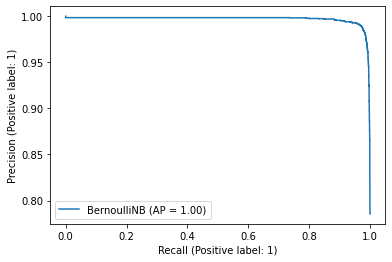

In [8]:
tryBest(p=0.2, method="BernoulliNB")

Comparación de ejecutar el test sobre el modelo de BernoulliNB con el mejor alpha en cada caso calculado al vuelo.<br>
Para el caso del **unigrama**:
```
80.0% - test
20.0% - validation
alpha: 0.1
F1-score of the test:  98.89%
Confusion Matrix:
[[1426   74]
 [  26 4474]]
```
Para el caso del **bigrama**:
```
80.0% - test
20.0% - validation
alpha: 1.8
F1-score of the test:  98.32%
Confusion Matrix:
[[1443   57]
 [  94 4406]]
```

80.0% - test
20.0% - validation
alpha: 0.15
F1-score of the test:  98.50%
Confusion Matrix:
[[1466   34]
 [ 100 4400]]


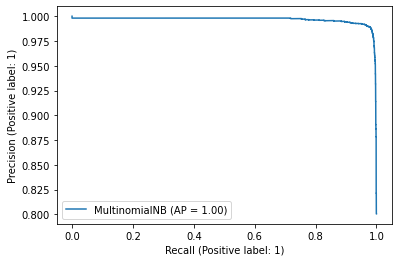

In [9]:
tryBest(p=0.2, method="MultinomialNB")

Comparación de ejecutar el test sobre el modelo de MultinomialNB con el mejor alpha en cada caso calculado al vuelo.<br>
Para el caso del **unigrama**:
```
80.0% - test
20.0% - validation
alpha: 0.2
F1-score of the test:  98.98%
Confusion Matrix:
[[1438   62]
 [  30 4470]]
```
Para el caso del **bigrama**:
```
80.0% - test
20.0% - validation
alpha: 0.15
F1-score of the test:  98.50%
Confusion Matrix:
[[1466   34]
 [ 100 4400]]
```

In [10]:
y_pred = classifier.predict(X_test)

encontrado = [False, False, False, False]
resultados ={
  "HH":{
      "texto":"",
      "contenido":[],
      "bag":{},
  },
  "HS":{
      "texto":"",
      "contenido":[],
      "bag":{},
  },
  "SH":{
      "texto":"",
      "contenido":[],
      "bag":{},
  },
  "SS":{
      "texto":"",
      "contenido":[],
      "bag":{},
  },
}

for i, t in enumerate(zip(mails_test, y_test, y_pred)):
  # print(f"{i} - {t}")
  if t[1] == t[2] and t[1] == 1 and not encontrado[0]:
    encontrado[0] = True
    resultados["HH"]["texto"] = t[0]
    resultados["HH"]["contenido"] = t[0].split()
  elif t[1] != t[2] and t[1] == 0 and not encontrado[1]:
    encontrado[1] = True
    resultados["HS"]["texto"] = t[0]
    resultados["HS"]["contenido"] = t[0].split()
  elif t[1] != t[2] and t[1] == 1 and not encontrado[2]:
    encontrado[2] = True
    resultados["SH"]["texto"] = t[0]
    resultados["SH"]["contenido"] = t[0].split()
  elif t[1] == t[2] and t[1] == 0 and not encontrado[3]:
    encontrado[3] = True
    resultados["SS"]["texto"] = t[0]
    resultados["SS"]["contenido"] = t[0].split()
  elif encontrado[0] == True and encontrado[1] == True and encontrado[2] == True and encontrado[3] == True:
    break

print(
"""
Lista de palabras pertenecientes a los emails analizados y detetados como uno de cada tipo.
Estas bolsas de palabras contendran aquellas palabras que han hecho que el clasificador
se decante por detectar el correo como spam o ham.
"""
)
print(resultados["HH"]["contenido"])
print(resultados["HS"]["contenido"])
print(resultados["SH"]["contenido"])
print(resultados["SS"]["contenido"])


Lista de palabras pertenecientes a los emails analizados y detetados como uno de cada tipo.
Estas bolsas de palabras contendran aquellas palabras que han hecho que el clasificador
se decante por detectar el correo como spam o ham.

['Subject:', 'king', 'britt', 'in', 'portugal', '[', 'april', '15', ',', '16', ',', '17', ']', 'o', 'seu', 'email', 'foi', 'registado', 'na', 'base', 'de', 'dados', 'da', 'heart', 'soul', '.', 'se', 'desejar', 'ser', 'removido', 'desta', 'base', 'de', 'dados', ',', 'envie', 'um', 'email', 'para', 'remove', '@', 'heartandsoul', '.', 'pt']
['Subject:', 'eol', 'webtext', 'here', 'is', 'my', 'proposed', 'webtext', 'for', 'fts', '-', '1', '.', 'note', 'i', "'", 've', 'left', 'blanks', 'for', 'you', 'to', 'fill', 'in', 'points', '.', 'text', 'for', 'other', 'services', 'is', 'forthcoming', '.']
['Subject:', 'post', 'secondary', 'certificates', 'for', 'sale', 'here', 'you', 'still', 'don', "'", 't', 'have', 'a', 'unioversity', 'deogree', '?', 'lack', 'of', 'post',

In [11]:
def getBag(palabras) -> dict:
  """
  devuelve un diccionario: {palabra: veces que aparece en la lista}
  """
  palabras = list(filter(lambda p: p.isalpha(), palabras))

  frecuencias = []
  for w in palabras:
    frecuencias.append(palabras.count(w))

  data = list(set(zip(palabras, frecuencias)))
  diccionario = {}
  for key, value in data:
    diccionario.update({key : value})
  return diccionario

resultados["HH"]["bag"] = getBag(resultados["HH"]["contenido"])
resultados["HS"]["bag"] = getBag(resultados["HS"]["contenido"])
resultados["SH"]["bag"] = getBag(resultados["SH"]["contenido"])
resultados["SS"]["bag"] = getBag(resultados["SS"]["contenido"])

dicRes = {
    "HH":[],
    "HS":[],
    "SH":[],
    "SS":[],
}

# Elimina la coincidencia de palabras entra las distintas bolsas
# de tal manera que se queda con listas únicas de palabras
for dict1 in resultados:
  for dict2 in resultados:
    if dict2 != dict1:
      # comparo los datos de d1 y filtro con dict2
      dicRes[dict1] = resultados[dict1]["bag"]  # copia de la bolsa de dict1
      aux = dicRes[dict1].copy()
      for key in aux:
        if key in resultados[dict2]["bag"]:
          dicRes[dict1].pop(key)

# Muestra las palabras que el mail detectado como: [HH | HS | SH | SS] no coparte con el 
# resto de los mails pertenecientes a la lista [HH, HS, SH, SS]
print("Lista de palabras de las que se han eliminado las coincidencias entre estas:\n")
print( dicRes["HH"] )
print( dicRes["HS"] )
print( dicRes["SH"] )
print( dicRes["SS"] )

# print("Correos detectados:\n")
# print( resultados["HH"]["contenido"] )  # Este mail ha sido detectado como HAM  y es correcto
# print( resultados["HS"]["contenido"] )  # Este mail ha sido detectado como SPAM y es incorrecto
# print( resultados["SH"]["contenido"] )  # Este mail ha sido detectado como HAM  y es incorrecto
# print( resultados["SS"]["contenido"] )  # Este mail ha sido detectado como SPAM y es correcto

Lista de palabras de las que se han eliminado las coincidencias entre estas:

{'dados': 2, 'de': 2, 'removido': 1, 'um': 1, 'desejar': 1, 'heartandsoul': 1, 'britt': 1, 'remove': 1, 'foi': 1, 'ser': 1, 'o': 1, 'april': 1, 'pt': 1, 'desta': 1, 'se': 1, 'heart': 1, 'soul': 1, 'para': 1, 'portugal': 1, 'seu': 1, 'registado': 1, 'da': 1, 'base': 2, 'envie': 1, 'na': 1}
{'text': 1, 'fill': 1, 'left': 1, 'points': 1, 'note': 1, 'eol': 1, 'fts': 1, 'forthcoming': 1, 've': 1, 'blanks': 1, 'webtext': 2, 'other': 1, 'my': 1, 'proposed': 1}
{'important': 1, 'which': 3, 'wyman': 1, 'hybrids': 1, 'tyson': 1, 'heaps': 1, 'deogree': 1, 'lead': 1, 'machine': 1, 'established': 1, 'missionary': 1, 'me': 1, 'aspect': 1, 'discussion': 1, 'interesting': 1, 'education': 1, 'complicated': 1, 'still': 1, 'think': 1, 'starting': 1, 'commonly': 1, 'unioversity': 1, 'claims': 1, 'undermine': 1, 'quoted': 1, 'sure': 1, 'focuses': 1, 'intelligence': 1, 'claimed': 1, 'leaving': 2, 'was': 2, 'experimentally': 1, 'ar

## Conclusiones

Tras haber realizado las pruebas anteriores he llegado a la conclusión de que parece ser un buen clasificador de SPAM, aunque no sea perfecto esta muy cerca de serlo.<br>
El **F1-score** ha mostrado siempre un valor por encima de 95% siendo el valor mas alto obtenido el caso del clasificador multinomial con la configuración de unigrama con un 98.98% de puntuación.<br>
La **matriz de confusión** muestra en su diagonal principal la gran mayoria de mails tanto de SPAM como de HAM por lo que en cualquiera de las 4 pruebas se ha obtenido un resultado satisfactorio siendo asi reconocidos la mayoria de mails SPAM.
En cuanto al resultado mostrado por la curva precisión-recall se podria decir que tiene buena pinta al acercarse bastante al 1 diciendo asi que:
1.   Los elementos detectados son SPAM
2.   De aquellos que detecta como SPAM la gran mayoria de ellos lo son de verdad.

<br>
Un umbral para el precision-recall podria ser: [0.98, 0.98] en ambos casos ya que es el momento en el que la curva está en su punto central +- diciendo así que hay una buena proporción entre aquellos mails que se dicen que son SPAM y los que realmente son SPAM.

De aquellos correos analizados con el clasificador he cogido 4, uno de cada tipo para comparar las palabras que utilizan cada uno de ellos y entender como el clasificador ha podido hacer su elección.
En las pruebas realizada en las 2 celdas de código anteriores lo que he hecho ha sido:
1. Dectectar un correo de cada tipo: [ham-ham | ham-spam | spam-ham | spam spam]
2. Una vez detectados estos, he creado una bolsa de palabras en base al contenido del mail.
3. He quitado aquellas palabras que pertenecian a alguno de los otros mails para quedarme con aquellas que eran propias de esos mails.
4. he revisado el contenido del mail para entender +- que palabras han podido ser las responsables de esta decisión. (Al hacer la eliminación de palabras repetidas/compartidas en uno de los 4 mails soy consciente de que las palabras que estaban en el mail de spam también estaría probablemente en el detectado como spam pero que es ham eliminando así aquellas palabras que podrían resultar más relevantes para entender que palabras ha usado el clasificador para decir que es spam)

Sobre el uso de bi-gramas resulta que el clasificador a la hora de coger palabras para clasificarlas en vez de coger de 1 en 1 las coge de 2 en 2.
Mientras buscaba información al respecto de uso de n-gramas encontre un sitio en el que afirmaban que la mejor configuración para el filtro de spam era un 4-5, probe ambas configuraciones pero salió mal el experimento.
